# ML Cup

Import our own neural network code aswell as numpy and pandas for data handling and loading.

In [13]:
import numpy as np
import pandas as pd
from network import *
from sklearn.preprocessing import StandardScaler
from train_utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

Read the data into pandas dataframes, remove empty first column, remove ids, split into variables and class labels, convert to numpy arrays.

In [2]:
X_df = pd.read_csv("data/cup/ML-CUP25-TR.csv", sep=",", comment="#", header=None)
XBT_df = pd.read_csv("data/cup/ML-CUP25-TS.csv", sep=",", comment="#", header=None)

Y_df = X_df[[13, 14, 15, 16]]
X_df = X_df.drop(columns=[0, 13, 14, 15, 16])
XBT_df = XBT_df.drop(columns=[0])

print(X_df.shape)
print(X_df.head())
print(Y_df.shape)
print(Y_df.head())
print(XBT_df.shape)
print(XBT_df.head())

X = X_df.to_numpy()
Y = Y_df.to_numpy()
XBT = XBT_df.to_numpy()

(500, 12)
          1          2          3          4         5         6          7   \
0  -6.925642  -6.093158  -9.149763  -5.918488  4.391259 -1.059304  -5.031085   
1  -5.649870  -7.650998 -10.407383  -7.864047  3.790306 -1.673732  -8.493233   
2  15.985886  14.192953  24.466835  12.551305 -7.788409  0.557977  23.145951   
3  12.774004  10.156462  18.588934   8.346695 -5.245173 -0.199274  14.500231   
4  -4.019226  -4.043457  -5.095354  -3.147125  0.725466 -0.477673  -4.025913   

          8          9          10         11         12  
0  -6.932177  -5.805652   7.147028   4.555533  -5.694865  
1  -8.143588  -9.447557  10.790796   6.266211  -5.551301  
2  20.031774  14.516358 -21.024198 -10.410913  12.061133  
3  12.608063  12.411055 -15.479452  -8.871887   6.703585  
4  -0.995364  -3.491760   3.385533   1.838361  -4.271710  
(500, 4)
          13         14         15         16
0   6.554997  10.688732  15.416160  -7.535628
1  12.342252  -8.135250  23.787661  -3.270978
2  28.54

Scale the features.

In [3]:
X = StandardScaler().fit_transform(X)
XBT = StandardScaler().fit_transform(XBT)

X

array([[-0.88733074, -0.81159466, -0.73626082, ...,  0.73052709,
         0.83883143, -0.92278791],
       [-0.76318039, -0.96810341, -0.81269752, ...,  1.02119652,
         1.09256129, -0.9028031 ],
       [ 1.34227906,  1.22645517,  1.30691755, ..., -1.51673883,
        -1.38101066,  1.5489333 ],
       ...,
       [ 1.0711801 ,  1.07026272,  1.42800213, ..., -1.22023228,
        -1.42278381,  1.2695007 ],
       [-0.90892053, -1.26616062, -1.25202302, ...,  1.05068417,
         0.99456614, -1.03309211],
       [ 0.93705775,  0.62131415,  0.79163565, ..., -0.63697812,
        -0.57424952,  0.53928755]], shape=(500, 12))

## Initial Training
We first train with hould-out validation and hold-out test to see if training works at all.

Split data into train and validation sets, using 80% of the data for train and 20% for validation. The test set is already given as part of the dataset.

In [4]:
def split_data(X, Y, val_fraction=0.15, test_fraction=0.15, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)

    val_size = int(n * val_fraction)
    test_size = int(n * test_fraction)
    train_size = n - val_size - test_size

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_val = X[val_indices]
    Y_val = Y[val_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

XTr, YTr, XVl, YVl, XT, YT = split_data(X, Y)
print(XTr.shape, YTr.shape, XVl.shape, YVl.shape, XT.shape, YT.shape)

(350, 12) (350, 4) (75, 12) (75, 4) (75, 12) (75, 4)


Define datasets and dataloaders.

In [5]:
XTr_dl = DataLoader(Dataset(XTr, YTr), batch_size=32, shuffle=True)
XVl_dl = DataLoader(Dataset(XVl, YVl), batch_size=32, shuffle=False)
XT_dl = DataLoader(Dataset(XT, YT), batch_size=32, shuffle=False)

Train a small model to see if training works at all.

In [6]:
model = Model(
    LinearLayer(12, 32),
    ReLU(),
    LinearLayer(32, 32),
    ReLU(),
    LinearLayer(32, 4),
)
loss_fn = MSELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.01, weight_decay=0.01)


for epoch in range(100):
    # Train
    train_total_n = 0
    train_losses = 0.0
    train_errors = 0.0
    for x_batch, y_batch in XTr_dl:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        optimizer.step()
        train_total_n += y_batch.shape[0]
        train_losses += loss * y_batch.shape[0]
        result = np.sqrt(np.sum((y_pred - y_batch) ** 2, axis=1))
        train_errors += np.sum(result)

    # Validate
    val_total_n = 0
    val_losses = 0.0
    val_errors = 0.0
    for x_batch, y_batch in XVl_dl:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        val_total_n += y_batch.shape[0]
        val_losses += loss * y_batch.shape[0]
        result = np.sqrt(np.sum((y_pred - y_batch) ** 2, axis=1))
        val_errors += np.sum(result)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_losses / train_total_n:.4f} | Train MEE: {train_errors / train_total_n:.4f} | Val Loss: {val_losses / val_total_n:.4f} | Val MEE: {val_errors / val_total_n:.4f}")

Epoch 001 | Train Loss: 335.4946 | Train MEE: 33.2765 | Val Loss: 261.3563 | Val MEE: 29.3786
Epoch 002 | Train Loss: 223.5772 | Train MEE: 27.2323 | Val Loss: 211.9817 | Val MEE: 26.6390
Epoch 003 | Train Loss: 207.6745 | Train MEE: 26.1430 | Val Loss: 195.9426 | Val MEE: 25.5924
Epoch 004 | Train Loss: 200.9867 | Train MEE: 25.7350 | Val Loss: 197.5876 | Val MEE: 25.6722
Epoch 005 | Train Loss: 198.3200 | Train MEE: 25.5732 | Val Loss: 192.8189 | Val MEE: 25.3321
Epoch 006 | Train Loss: 196.2522 | Train MEE: 25.3693 | Val Loss: 194.9378 | Val MEE: 25.4476
Epoch 007 | Train Loss: 194.3903 | Train MEE: 25.2705 | Val Loss: 190.5525 | Val MEE: 25.1332
Epoch 008 | Train Loss: 192.4340 | Train MEE: 25.1062 | Val Loss: 189.7854 | Val MEE: 25.0195
Epoch 009 | Train Loss: 190.0165 | Train MEE: 24.8799 | Val Loss: 187.6284 | Val MEE: 24.8537
Epoch 010 | Train Loss: 187.7078 | Train MEE: 24.7341 | Val Loss: 184.8155 | Val MEE: 24.6599
Epoch 011 | Train Loss: 184.9706 | Train MEE: 24.5274 | Val 

In [7]:
# Test
test_total_n = 0
test_losses = 0.0
test_errors = 0.0
for x_batch, y_batch in XT_dl:
    y_pred = model.forward(x_batch)
    loss = loss_fn.forward(y_pred, y_batch)
    test_total_n += y_batch.shape[0]
    test_losses += loss * y_batch.shape[0]
    result = np.sqrt(np.sum((y_pred - y_batch) ** 2, axis=1))
    test_errors += np.sum(result)

print(f"Test Loss: {test_losses / test_total_n:.4f} | Test MEE: {test_errors / test_total_n:.4f}")

Test Loss: 122.6492 | Test MEE: 19.9741


Because we did not scale the target variables, the MEE value is meaningless. We calculate what an blind model that would just output the standard deviation of the training data would end up having as MEE.

In [8]:
std_targets = np.std(YTr, axis=0)
mee = np.sqrt(np.sum(std_targets ** 2))
print(f"Blind model MEE: {mee}")

Blind model MEE: 38.55977061231263


## Cross Validation + Grid Search
Now that we have a basic model that is able to learn, we do a cross validation with grid search and hold out the test set. Why no nested cross validation? Nested cross validation does not give us a final "best" model, it only makes assessing the risk more accurate (because it uses more data). Given the higher computational complexity, we opt to just hold out the test set.

The relevant functions are in `train_utils.py`.

In [35]:
parameters = dict(
    learning_rates = [0.001, 0.005, 0.01, 0.05],
    weight_decays = [0.001, 0.005, 0.01, 0.05],
    input_size = 12,
    hidden_units_layer_1 = [32, 64, 128],
    hidden_units_layer_2 = [32, 64, 128],
    hidden_units_layer_3 = [0, 32, 64, 128],
    output_size = 4,
    batch_sizes = [32],
    activations_hidden_layer = [ReLU],
    activations_output_layer = [None],
    loss_functions = [MSELoss],
    optimizers = [AdamWOptimizer],
)

cfgs = generate_param_cfgs(parameters)
print(len(cfgs))
print(cfgs[0])

576
{'learning_rate': 0.001, 'weight_decay': 0.001, 'input_size': 12, 'hidden_units_layer_1': 32, 'hidden_units_layer_2': 32, 'hidden_units_layer_3': 0, 'batch_size': 32, 'output_size': 4, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': None, 'loss_function': <class 'network.mse.MSELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}


In [12]:
# Combine training and validation sets for cross-validation
XTr_Vl = np.vstack([XTr, XVl])
YTr_Vl = np.vstack([YTr, YVl])
print(XTr_Vl.shape, YTr_Vl.shape)

results = grid_search_cross_validate(XTr_Vl, YTr_Vl, cfgs, final_metric_fn=mean_euclidean_error)
best_cfg, best_result, epochs = min(results, key=lambda x: x[1])
print("Best config:", best_cfg)
print(f"Best validation MEE: {best_result:.4f}")
print(f"Used epochs: {epochs}")

(425, 12) (425, 4)


100%|██████████| 768/768 [25:18<00:00,  1.98s/it]

Best config: {'learning_rate': 0.01, 'weight_decay': 0.005, 'input_size': 12, 'hidden_units_layer_1': 64, 'hidden_units_layer_2': 64, 'hidden_units_layer_3': 64, 'batch_size': 32, 'output_size': 4, 'activation_hidden_layer': <class 'network.relu.ReLU'>, 'activation_output_layer': None, 'loss_function': <class 'network.mse.MSELoss'>, 'optimizer': <class 'network.adam.AdamWOptimizer'>}
Best validation acc: 21.9455
Used epochs: 29


Test Loss: 116.4360 | Test MEE: 19.4969


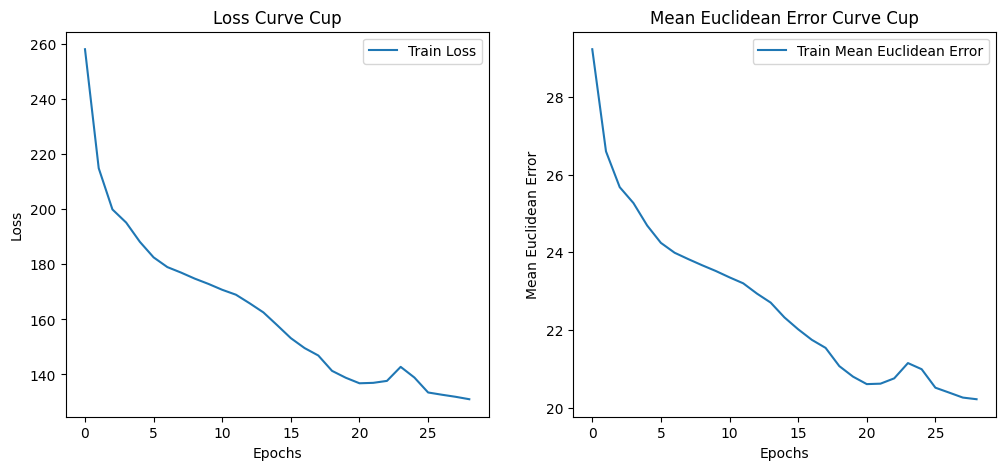

In [14]:
XTr_Vl_dl = DataLoader(Dataset(XTr_Vl, YTr_Vl), batch_size=best_cfg['batch_size'], shuffle=False)

best_model = create_model(best_cfg)
loss_fn = best_cfg['loss_function']()
optimizer = best_cfg['optimizer'](best_model, learning_rate=best_cfg['learning_rate'], weight_decay=best_cfg['weight_decay'])
# Train on full training data
best_model, _, _, curves1 = train_model(best_model, loss_fn, optimizer, XTr_Vl_dl, None, mean_euclidean_error, max_epochs=epochs)
# Test on test data
test_loss, test_mee = epoch_run(best_model, loss_fn, None, XT_dl, mean_euclidean_error, update_weights=False)
print(f"Test Loss: {test_loss:.4f} | Test MEE: {test_mee:.4f}")

# Plot only train loss and MEE curves since we dont have validation data here
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(curves1['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve Cup')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves1['train_final_metric'], label='Train Mean Euclidean Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Euclidean Error')
plt.title('Mean Euclidean Error Curve Cup')
plt.legend()
plt.show()

Use the final model to predict the blind test set.

In [ ]:
# Batch size does not matter here technically
# Very important to set shuffle=False here to preserve order
XBT_dl = DataLoader(Dataset(XBT, np.zeros((XBT.shape[0], 1))), batch_size=best_cfg['batch_size'], shuffle=False)
predictions = []
for x_batch, _ in XBT_dl:
    y_pred = best_model.forward(x_batch)
    predictions.append(y_pred)
predictions = np.vstack(predictions)
print(predictions.shape)

with open("./Team-GER_ML-CUP25-TS.csv", "w") as f:
    f.write("# Jaanis Fehling, Mikael Caselitz\n")
    f.write("# Team GER\n")
    f.write("# ML-CUP25 v1\n")
    f.write("# 31 Dec 2025\n")
    for i, row in enumerate(predictions):
        f.write(f"{i+1},")
        f.write(",".join([f"{val}" for val in row]) + "\n")

(1000, 4)


In [ ]:
# Test read the predictions file
pred_df = pd.read_csv("./Team-GER_ML-CUP25-TS.csv", comment="#", header=None)
print(pred_df.head())

   0          1          2          3          4
0  1  -3.081702  -4.670476   7.580528  -7.592914
1  2  -1.096486  12.369516 -42.340820  12.751820
2  3  -0.353383  -1.812286 -11.486346   4.250770
3  4  -6.075629 -16.380686 -14.994850  20.837414
4  5  18.211463  -6.872034 -16.749310  34.254507


In [ ]:
# Short description of method used
with open("./Team-GER_abstract.txt", "w") as f:
    f.write(f"Custom neural network implemented using numpy.\n")
    f.write("Architecture: ")
    for layer in best_model.layers:
        if isinstance(layer, LinearLayer):
            f.write(f"LinearLayer({layer.input_size}, {layer.output_size}), ")
        else:
            f.write(f"{type(layer).__name__}, ")
    f.write("\n")
    f.write(f"Trained using MSE Loss and AdamW optimizer with learning rate {best_cfg['learning_rate']} and weight decay {best_cfg['weight_decay']}.\n")
    f.write("Grid Search + Cross Validation and holding out the test set.\n")
    f.write(f"Batch size {best_cfg['batch_size']}, early stopping with patience 5, trained in {epochs} Epochs.")